### Importing the training set

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob

In [2]:
import glob
vehc = glob.glob('./Trainingdatasets/vehicles/**/*.png')
non_vehc = glob.glob('./Trainingdatasets/non-vehicles/**/*.png')

In [3]:
import cv2
import numpy as np

car = []
for i in range(len(vehc)):
    img = mpimg.imread(vehc[i])
    car.append(img)

non_car = []
for i in range(len(non_vehc)):
    img = mpimg.imread(non_vehc[i])
    non_car.append(img)

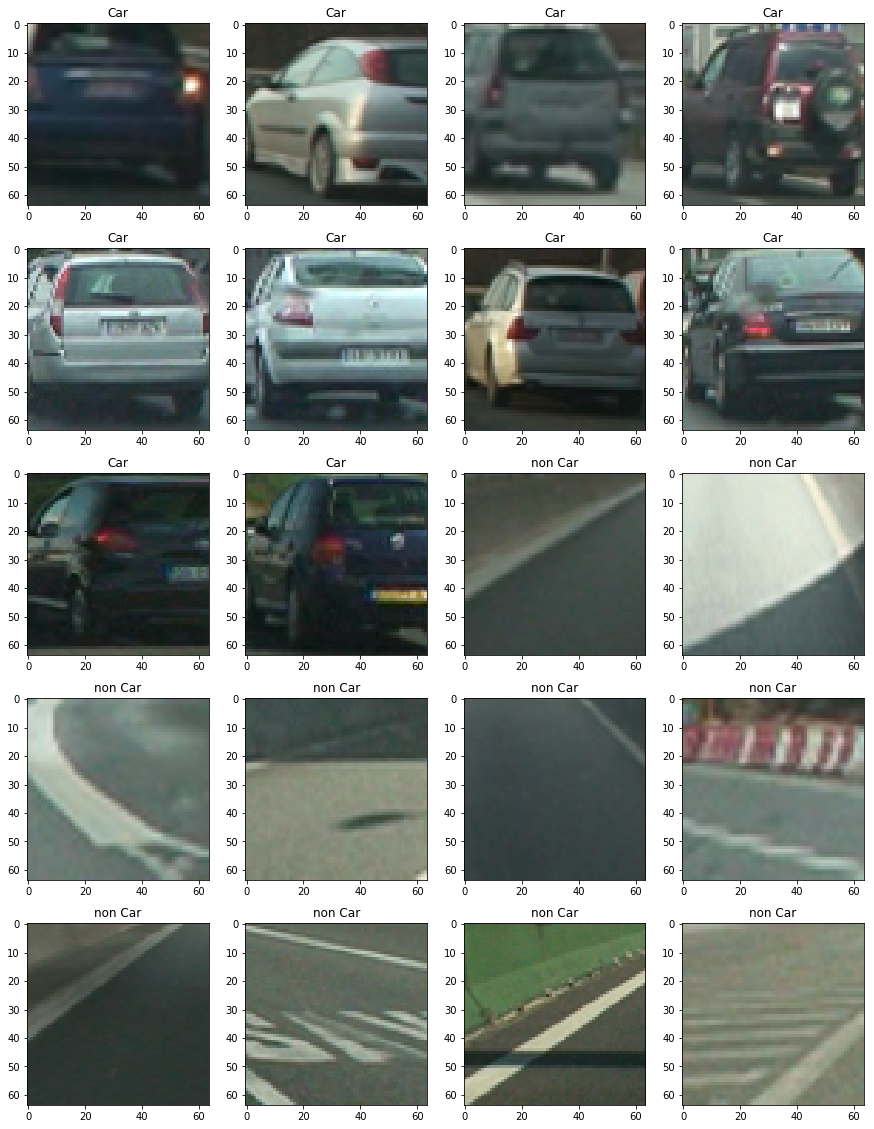

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,20))
k = 1
while k < 11:
    plt.subplot(5,4,k)
    plt.imshow(car[k])
    plt.title('Car')
    plt.subplot(5,4,k+10)
    plt.imshow(non_car[k])
    plt.title('non Car')
    k = k+1


### Convert Image to Histogram of Oriented Gradients (HOG)

In [5]:
from skimage.feature import hog
import matplotlib.image as mpimg

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
f,i = get_hog_features(car[2], 9, 8, 8, vis=True, feature_vec=True)

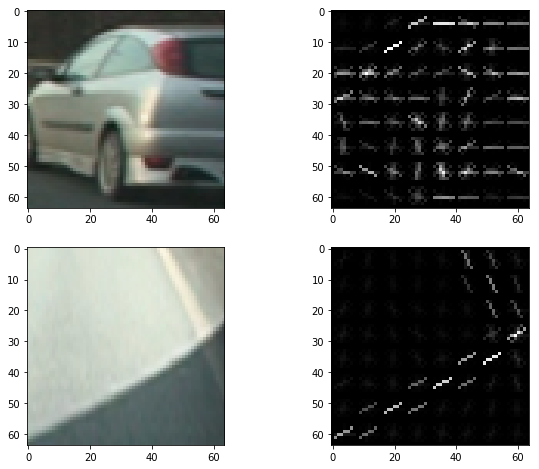

In [7]:
plt.figure(figsize = (10,8))
plt.subplot(2,2,1)
plt.imshow(car[2])
f,i = get_hog_features(car[2], 9, 8, 8, vis=True, feature_vec=True)
plt.subplot(2,2,2)
plt.imshow(i, cmap = 'gray')
plt.subplot(2,2,3)
plt.imshow(non_car[2])
f,i = get_hog_features(non_car[2], 9, 8, 8, vis=True, feature_vec=True)
plt.subplot(2,2,4)
plt.imshow(i, cmap = 'gray')

### Extracting the features

In [8]:
import matplotlib.image as mpimg

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        feature_image = []
        # Read in each one by one
        image = file
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [9]:
from sklearn.model_selection import train_test_split
# Feature extraction parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, HLS
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

car_features = extract_features(car, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(non_car, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
#print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292


In [10]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
# Check the training time for the SVC
clf.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample

Test Accuracy of SVC =  0.984


In [11]:
'''conditions = []
colSpace = {'RGB','HLS','LUV','YUV','YCrCb'}
orient = [6,9,12]
pixPcell = [8,16]
cellPblock = [1,2,3]
HOGChannel = {0,1,2,'ALL'}
for i in colSpace:
    for j in orient:
        for k in pixPcell:
            for m in cellPblock:
                for n in HOGChannel:
                    car_features = extract_features(car,
                                                    cspace=i,
                                                    orient=j,
                                                    pix_per_cell=k,
                                                    cell_per_block=m,
                                                    hog_channel=n)
                    notcar_features = extract_features(non_car,
                                                       cspace=i,
                                                       orient=j,pix_per_cell=k,
                                                       cell_per_block=m,
                                                       hog_channel=n)
                    X = np.vstack((car_features, notcar_features)).astype(np.float64)
                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
                    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                        y, 
                                                                        test_size=0.2,
                                                                        random_state=3)
                    clf = clf.fit(X_train, y_train)
                    
                    score = clf.score(X_test[0:20],y_test[0:20])
                    
                    print([i,j,k,m,n,score])
                    cond = [i,j,k,m,n,score]
                    conditions.append(cond)'''

"conditions = []\ncolSpace = {'RGB','HLS','LUV','YUV','YCrCb'}\norient = [6,9,12]\npixPcell = [8,16]\ncellPblock = [1,2,3]\nHOGChannel = {0,1,2,'ALL'}\nfor i in colSpace:\n    for j in orient:\n        for k in pixPcell:\n            for m in cellPblock:\n                for n in HOGChannel:\n                    car_features = extract_features(car,\n                                                    cspace=i,\n                                                    orient=j,\n                                                    pix_per_cell=k,\n                                                    cell_per_block=m,\n                                                    hog_channel=n)\n                    notcar_features = extract_features(non_car,\n                                                       cspace=i,\n                                                       orient=j,pix_per_cell=k,\n                                                       cell_per_block=m,\n                            

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, clf, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        else: ctrans_tosearch = np.copy(img)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = clf.predict([hog_features])
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [13]:
from sklearn.preprocessing import StandardScaler

test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 464
scale = 1
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb,HLS
#orient = 11
#pix_per_cell = 8
#cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, clf, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

1 rectangles found in image


In [14]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

...


...


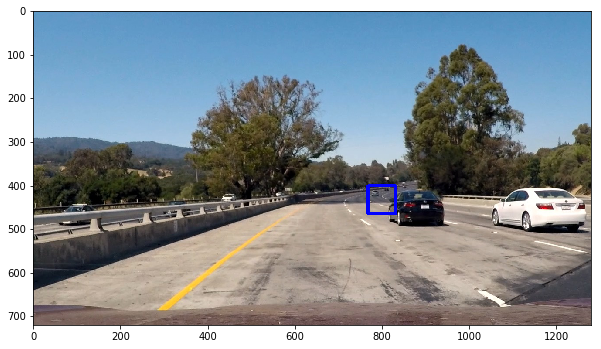

In [15]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('...')

Number of boxes:  327


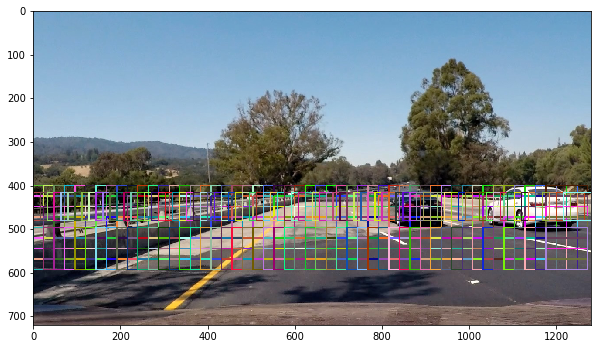

In [16]:
test_img = mpimg.imread('./test_images/test4.jpg')

rects = []

ystart = 400
ystop = 596
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, clf, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, clf
                       , None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

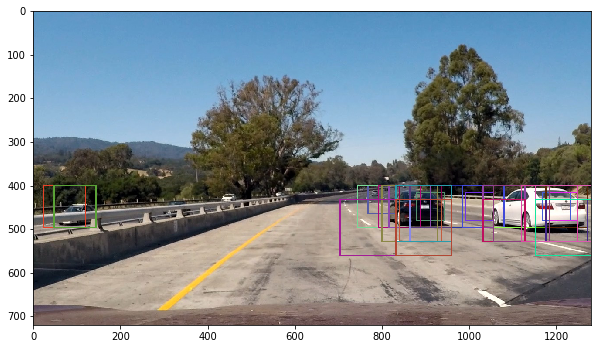

In [17]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
svc = clf

ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('...')

...


...


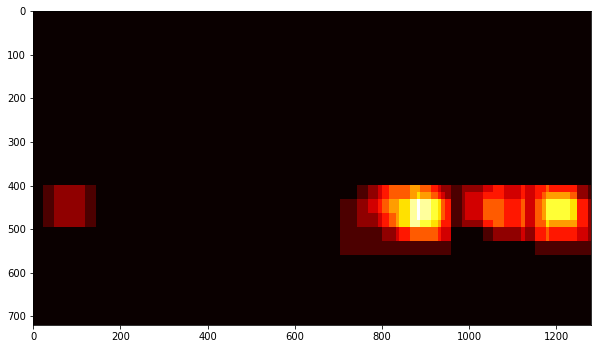

In [19]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

In [20]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('...')

...


...


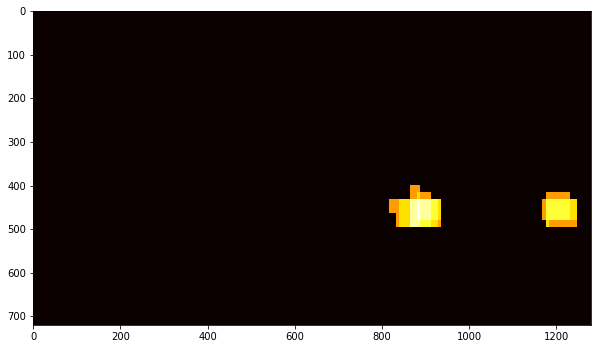

In [21]:
heatmap_img = apply_threshold(heatmap_img, 5)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

2 cars found


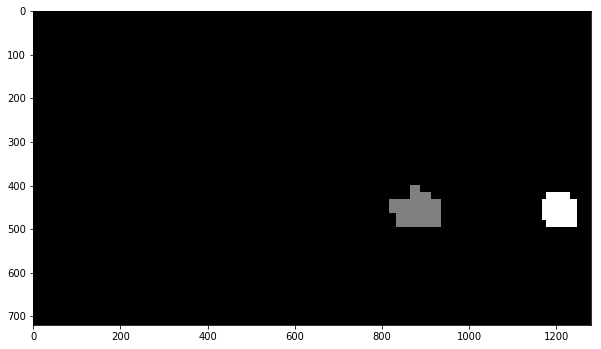

In [22]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

...


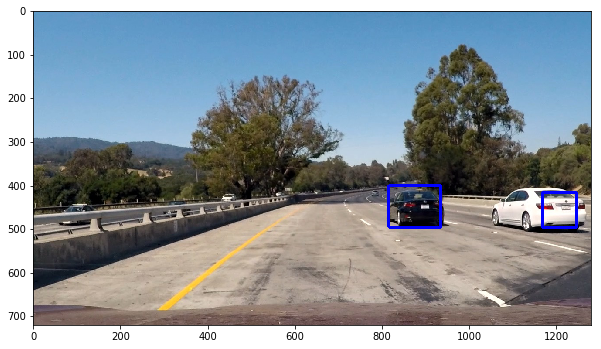

In [23]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
print('...')

In [34]:
def process_frame(img):

    rectangles = []

    colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 4)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

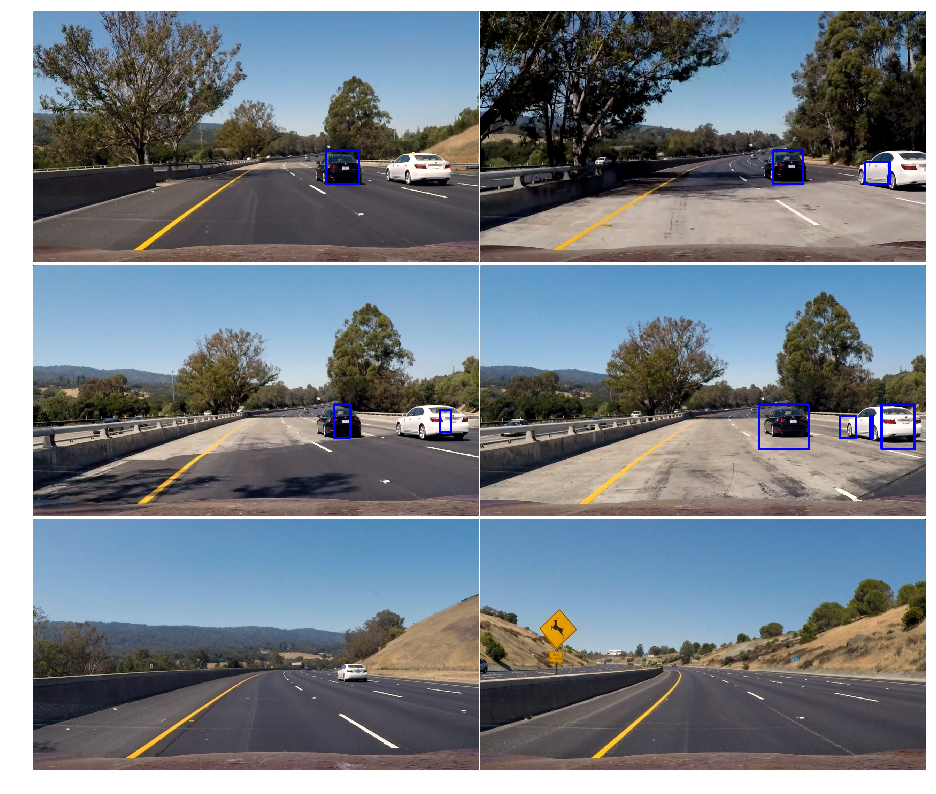

In [35]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [36]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:00<00:15,  2.45it/s]

  5%|▌         | 2/39 [00:00<00:14,  2.51it/s]

  8%|▊         | 3/39 [00:01<00:14,  2.53it/s]

 10%|█         | 4/39 [00:01<00:13,  2.52it/s]

 13%|█▎        | 5/39 [00:01<00:13,  2.52it/s]

 15%|█▌        | 6/39 [00:02<00:13,  2.52it/s]

 18%|█▊        | 7/39 [00:02<00:12,  2.51it/s]

 21%|██        | 8/39 [00:03<00:12,  2.52it/s]

 23%|██▎       | 9/39 [00:03<00:11,  2.52it/s]

 26%|██▌       | 10/39 [00:03<00:11,  2.53it/s]

 28%|██▊       | 11/39 [00:04<00:11,  2.53it/s]

 31%|███       | 12/39 [00:04<00:10,  2.54it/s]

 33%|███▎      | 13/39 [00:05<00:10,  2.54it/s]

 36%|███▌      | 14/39 [00:05<00:09,  2.54it/s]

 38%|███▊      | 15/39 [00:05<00:09,  2.55it/s]

 41%|████      | 16/39 [00:06<00:09,  2.55it/s]

 44%|████▎     | 17/39 [00:06<00:08,  2.55it/s]

 46%|████▌     | 18/39 [00:07<00:08,  2.55it/s]

 49%|████▊     | 19/39 [00:07<00:07,  2.54it/s]

 51%|█████▏    | 20/39 [00:07<00:07,

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 14.7 s, sys: 996 ms, total: 15.7 s
Wall time: 16.1 s


In [37]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<08:18,  2.53it/s]

  0%|          | 2/1261 [00:00<08:10,  2.57it/s]

  0%|          | 3/1261 [00:01<08:10,  2.56it/s]

  0%|          | 4/1261 [00:01<08:07,  2.58it/s]

  0%|          | 5/1261 [00:01<08:07,  2.57it/s]

  0%|          | 6/1261 [00:02<08:06,  2.58it/s]

  1%|          | 7/1261 [00:02<08:05,  2.58it/s]

  1%|          | 8/1261 [00:03<08:05,  2.58it/s]

  1%|          | 9/1261 [00:03<08:05,  2.58it/s]

  1%|          | 10/1261 [00:03<08:05,  2.58it/s]

  1%|          | 11/1261 [00:04<08:05,  2.58it/s]

  1%|          | 12/1261 [00:04<08:04,  2.58it/s]

  1%|          | 13/1261 [00:05<08:04,  2.58it/s]

  1%|          | 14/1261 [00:05<08:03,  2.58it/s]

  1%|          | 15/1261 [00:05<08:03,  2.58it/s]

  1%|▏         | 16/1261 [00:06<08:02,  2.58it/s]

  1%|▏         | 17/1261 [00:06<08:01,  2.58it/s]

  1%|▏         | 18/1261 [00:06<08:01,  2.58it/s]

  2%|▏         | 19/1261 [00:07<08:00,  2.58it/

 11%|█▏        | 143/1261 [00:58<07:34,  2.46it/s]

 11%|█▏        | 144/1261 [00:58<07:33,  2.46it/s]

 11%|█▏        | 145/1261 [00:58<07:33,  2.46it/s]

 12%|█▏        | 146/1261 [00:59<07:32,  2.46it/s]

 12%|█▏        | 147/1261 [00:59<07:32,  2.46it/s]

 12%|█▏        | 148/1261 [01:00<07:31,  2.46it/s]

 12%|█▏        | 149/1261 [01:00<07:30,  2.47it/s]

 12%|█▏        | 150/1261 [01:00<07:30,  2.47it/s]

 12%|█▏        | 151/1261 [01:01<07:29,  2.47it/s]

 12%|█▏        | 152/1261 [01:01<07:29,  2.47it/s]

 12%|█▏        | 153/1261 [01:01<07:28,  2.47it/s]

 12%|█▏        | 154/1261 [01:02<07:28,  2.47it/s]

 12%|█▏        | 155/1261 [01:02<07:27,  2.47it/s]

 12%|█▏        | 156/1261 [01:03<07:26,  2.47it/s]

 12%|█▏        | 157/1261 [01:03<07:26,  2.47it/s]

 13%|█▎        | 158/1261 [01:03<07:25,  2.48it/s]

 13%|█▎        | 159/1261 [01:04<07:25,  2.48it/s]

 13%|█▎        | 160/1261 [01:04<07:24,  2.48it/s]

 13%|█▎        | 161/1261 [01:04<07:24,  2.48it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [01:54<06:32,  2.49it/s]

 23%|██▎       | 285/1261 [01:54<06:32,  2.49it/s]

 23%|██▎       | 286/1261 [01:55<06:32,  2.48it/s]

 23%|██▎       | 287/1261 [01:55<06:31,  2.48it/s]

 23%|██▎       | 288/1261 [01:55<06:31,  2.48it/s]

 23%|██▎       | 289/1261 [01:56<06:31,  2.48it/s]

 23%|██▎       | 290/1261 [01:56<06:30,  2.48it/s]

 23%|██▎       | 291/1261 [01:57<06:30,  2.48it/s]

 23%|██▎       | 292/1261 [01:57<06:30,  2.48it/s]

 23%|██▎       | 293/1261 [01:58<06:29,  2.48it/s]

 23%|██▎       | 294/1261 [01:58<06:29,  2.48it/s]

 23%|██▎       | 295/1261 [01:58<06:29,  2.48it/s]

 23%|██▎       | 296/1261 [01:59<06:28,  2.48it/s]

 24%|██▎       | 297/1261 [01:59<06:28,  2.48it/s]

 24%|██▎       | 298/1261 [02:00<06:27,  2.48it/s]

 24%|██▎       | 299/1261 [02:00<06:27,  2.48it/s]

 24%|██▍       | 300/1261 [02:00<06:27,  2.48it/s]

 24%|██▍       | 301/1261 [02:01<06:26,  2.48it/s]

 24%|██▍       | 302/1261 [02:01<06:26,  2.48it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [02:51<05:37,  2.48it/s]

 34%|███▍      | 426/1261 [02:52<05:37,  2.48it/s]

 34%|███▍      | 427/1261 [02:52<05:36,  2.48it/s]

 34%|███▍      | 428/1261 [02:52<05:36,  2.48it/s]

 34%|███▍      | 429/1261 [02:53<05:35,  2.48it/s]

 34%|███▍      | 430/1261 [02:53<05:35,  2.48it/s]

 34%|███▍      | 431/1261 [02:53<05:34,  2.48it/s]

 34%|███▍      | 432/1261 [02:54<05:34,  2.48it/s]

 34%|███▍      | 433/1261 [02:54<05:34,  2.48it/s]

 34%|███▍      | 434/1261 [02:55<05:33,  2.48it/s]

 34%|███▍      | 435/1261 [02:55<05:33,  2.48it/s]

 35%|███▍      | 436/1261 [02:55<05:32,  2.48it/s]

 35%|███▍      | 437/1261 [02:56<05:32,  2.48it/s]

 35%|███▍      | 438/1261 [02:56<05:31,  2.48it/s]

 35%|███▍      | 439/1261 [02:57<05:31,  2.48it/s]

 35%|███▍      | 440/1261 [02:57<05:31,  2.48it/s]

 35%|███▍      | 441/1261 [02:57<05:30,  2.48it/s]

 35%|███▌      | 442/1261 [02:58<05:30,  2.48it/s]

 35%|███▌      | 443/1261 [02:58<05:29,  2.48it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [03:47<04:39,  2.49it/s]

 45%|████▍     | 567/1261 [03:47<04:38,  2.49it/s]

 45%|████▌     | 568/1261 [03:48<04:38,  2.49it/s]

 45%|████▌     | 569/1261 [03:48<04:38,  2.49it/s]

 45%|████▌     | 570/1261 [03:49<04:37,  2.49it/s]

 45%|████▌     | 571/1261 [03:49<04:37,  2.49it/s]

 45%|████▌     | 572/1261 [03:49<04:36,  2.49it/s]

 45%|████▌     | 573/1261 [03:50<04:36,  2.49it/s]

 46%|████▌     | 574/1261 [03:50<04:35,  2.49it/s]

 46%|████▌     | 575/1261 [03:50<04:35,  2.49it/s]

 46%|████▌     | 576/1261 [03:51<04:35,  2.49it/s]

 46%|████▌     | 577/1261 [03:51<04:34,  2.49it/s]

 46%|████▌     | 578/1261 [03:52<04:34,  2.49it/s]

 46%|████▌     | 579/1261 [03:52<04:33,  2.49it/s]

 46%|████▌     | 580/1261 [03:52<04:33,  2.49it/s]

 46%|████▌     | 581/1261 [03:53<04:32,  2.49it/s]

 46%|████▌     | 582/1261 [03:53<04:32,  2.49it/s]

 46%|████▌     | 583/1261 [03:53<04:32,  2.49it/s]

 46%|████▋     | 584/1261 [03:54<04:31,  2.49it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [04:41<03:40,  2.51it/s]

 56%|█████▌    | 708/1261 [04:42<03:40,  2.51it/s]

 56%|█████▌    | 709/1261 [04:42<03:39,  2.51it/s]

 56%|█████▋    | 710/1261 [04:42<03:39,  2.51it/s]

 56%|█████▋    | 711/1261 [04:43<03:39,  2.51it/s]

 56%|█████▋    | 712/1261 [04:43<03:38,  2.51it/s]

 57%|█████▋    | 713/1261 [04:43<03:38,  2.51it/s]

 57%|█████▋    | 714/1261 [04:44<03:37,  2.51it/s]

 57%|█████▋    | 715/1261 [04:44<03:37,  2.51it/s]

 57%|█████▋    | 716/1261 [04:45<03:37,  2.51it/s]

 57%|█████▋    | 717/1261 [04:45<03:36,  2.51it/s]

 57%|█████▋    | 718/1261 [04:45<03:36,  2.51it/s]

 57%|█████▋    | 719/1261 [04:46<03:35,  2.51it/s]

 57%|█████▋    | 720/1261 [04:46<03:35,  2.51it/s]

 57%|█████▋    | 721/1261 [04:47<03:34,  2.51it/s]

 57%|█████▋    | 722/1261 [04:47<03:34,  2.51it/s]

 57%|█████▋    | 723/1261 [04:47<03:34,  2.51it/s]

 57%|█████▋    | 724/1261 [04:48<03:33,  2.51it/s]

 57%|█████▋    | 725/1261 [04:48<03:33,  2.51it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [05:36<02:43,  2.52it/s]

 67%|██████▋   | 849/1261 [05:36<02:43,  2.52it/s]

 67%|██████▋   | 850/1261 [05:36<02:42,  2.52it/s]

 67%|██████▋   | 851/1261 [05:37<02:42,  2.52it/s]

 68%|██████▊   | 852/1261 [05:37<02:42,  2.52it/s]

 68%|██████▊   | 853/1261 [05:38<02:41,  2.52it/s]

 68%|██████▊   | 854/1261 [05:38<02:41,  2.52it/s]

 68%|██████▊   | 855/1261 [05:38<02:40,  2.52it/s]

 68%|██████▊   | 856/1261 [05:39<02:40,  2.52it/s]

 68%|██████▊   | 857/1261 [05:39<02:40,  2.52it/s]

 68%|██████▊   | 858/1261 [05:40<02:39,  2.52it/s]

 68%|██████▊   | 859/1261 [05:40<02:39,  2.52it/s]

 68%|██████▊   | 860/1261 [05:40<02:38,  2.52it/s]

 68%|██████▊   | 861/1261 [05:41<02:38,  2.52it/s]

 68%|██████▊   | 862/1261 [05:41<02:38,  2.52it/s]

 68%|██████▊   | 863/1261 [05:41<02:37,  2.52it/s]

 69%|██████▊   | 864/1261 [05:42<02:37,  2.52it/s]

 69%|██████▊   | 865/1261 [05:42<02:36,  2.52it/s]

 69%|██████▊   | 866/1261 [05:43<02:36,  2.52it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [16:39<04:34,  1.01s/it]

 79%|███████▊  | 990/1261 [16:39<04:33,  1.01s/it]

 79%|███████▊  | 991/1261 [16:40<04:32,  1.01s/it]

 79%|███████▊  | 992/1261 [16:40<04:31,  1.01s/it]

 79%|███████▊  | 993/1261 [16:41<04:30,  1.01s/it]

 79%|███████▉  | 994/1261 [16:41<04:29,  1.01s/it]

 79%|███████▉  | 995/1261 [16:41<04:27,  1.01s/it]

 79%|███████▉  | 996/1261 [16:42<04:26,  1.01s/it]

 79%|███████▉  | 997/1261 [16:42<04:25,  1.01s/it]

 79%|███████▉  | 998/1261 [16:43<04:24,  1.01s/it]

 79%|███████▉  | 999/1261 [16:43<04:23,  1.00s/it]

 79%|███████▉  | 1000/1261 [16:43<04:22,  1.00s/it]

 79%|███████▉  | 1001/1261 [16:44<04:20,  1.00s/it]

 79%|███████▉  | 1002/1261 [16:44<04:19,  1.00s/it]

 80%|███████▉  | 1003/1261 [16:45<04:18,  1.00s/it]

 80%|███████▉  | 1004/1261 [16:45<04:17,  1.00s/it]

 80%|███████▉  | 1005/1261 [16:45<04:16,  1.00s/it]

 80%|███████▉  | 1006/1261 [16:46<04:15,  1.00s/it]

 80%|███████▉  | 1007/1261 [16:46<04:13,  1.00it/s]

 80%

 89%|████████▉ | 1128/1261 [17:33<02:04,  1.07it/s]

 90%|████████▉ | 1129/1261 [17:33<02:03,  1.07it/s]

 90%|████████▉ | 1130/1261 [17:34<02:02,  1.07it/s]

 90%|████████▉ | 1131/1261 [17:34<02:01,  1.07it/s]

 90%|████████▉ | 1132/1261 [17:34<02:00,  1.07it/s]

 90%|████████▉ | 1133/1261 [17:35<01:59,  1.07it/s]

 90%|████████▉ | 1134/1261 [17:35<01:58,  1.07it/s]

 90%|█████████ | 1135/1261 [17:36<01:57,  1.07it/s]

 90%|█████████ | 1136/1261 [17:36<01:56,  1.08it/s]

 90%|█████████ | 1137/1261 [17:36<01:55,  1.08it/s]

 90%|█████████ | 1138/1261 [17:37<01:54,  1.08it/s]

 90%|█████████ | 1139/1261 [17:37<01:53,  1.08it/s]

 90%|█████████ | 1140/1261 [17:37<01:52,  1.08it/s]

 90%|█████████ | 1141/1261 [17:38<01:51,  1.08it/s]

 91%|█████████ | 1142/1261 [17:38<01:50,  1.08it/s]

 91%|█████████ | 1143/1261 [17:39<01:49,  1.08it/s]

 91%|█████████ | 1144/1261 [17:39<01:48,  1.08it/s]

 91%|█████████ | 1145/1261 [17:39<01:47,  1.08it/s]

 91%|█████████ | 1146/1261 [17:40<01:46,  1.08

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 8min 1s, sys: 27.8 s, total: 8min 28s
Wall time: 18min 24s
